In [2]:
%pip install numpy scikit-learn

### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [4]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [5]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [6]:
# en el atributo `data` accedemos al texto
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [7]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [8]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [9]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [10]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [11]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [12]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [13]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [14]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [15]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [16]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748])

In [17]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [18]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [19]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [20]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [21]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [22]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**NO cambiar el hiperparámetro ngram_range de los vectorizadores**.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.


# 1. Vectorizar documentos.
Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.


Se carga el dataset nuevamente para  hacer el trabajo desde cero

In [23]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(
    subset='train',
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42
)

test = fetch_20newsgroups(
    subset='test',
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42
)

X_train, y_train = train.data, train.target
X_test, y_test = test.data, test.target

print(f"train: {len(X_train)} documentos")
print(f"test:  {len(X_test)} documentos")
print(f"total de clases: {len(train.target_names)}")
print("primeras clases:", train.target_names[:5], "...")


train: 11314 documentos
test:  7532 documentos
total de clases: 20
primeras clases: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'] ...


para entender bien el dataset, primero quiero hacer un pequeño EDA

,n_palabras
count,11314.000000
mean,185.827382
std,523.971647
min,0.000000
25%,40.000000
50%,83.000000
75%,167.000000
max,11765.000000


,frecuencia
rec.sport.hockey,600
soc.religion.christian,599
rec.motorcycles,598
rec.sport.baseball,597
sci.crypt,595
sci.med,594
rec.autos,594
sci.space,593
comp.windows.x,593
comp.os.ms-windows.misc,591


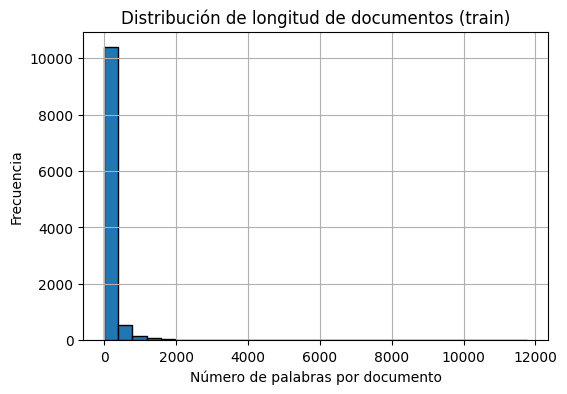

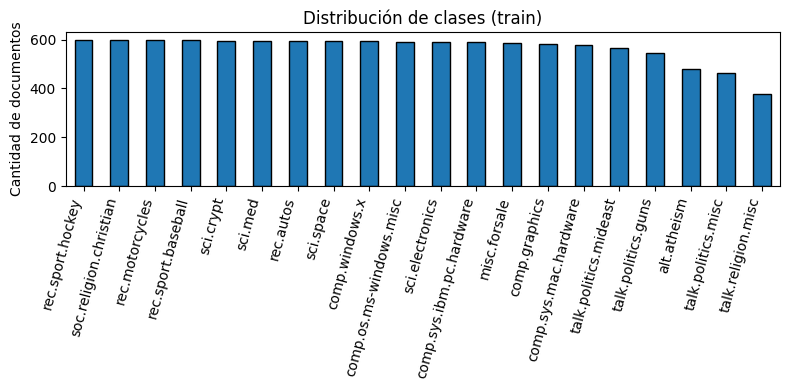

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

texts = X_train
labels = y_train
target_names = train.target_names

len_train = pd.Series([len(t.split()) for t in texts], name='n_palabras')
display(len_train.describe())

clases = pd.Series(labels).map(dict(enumerate(target_names)))
freq_clases = clases.value_counts().sort_values(ascending=False)
display(freq_clases.to_frame("frecuencia"))

plt.figure(figsize=(6,4))
len_train.hist(bins=30, edgecolor="black")
plt.title("Distribución de longitud de documentos (train)")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(8,4))
freq_clases.plot(kind="bar", edgecolor="black")
plt.title("Distribución de clases (train)")
plt.ylabel("Cantidad de documentos")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


Ahora procedemso a la vectorización

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vec_count = CountVectorizer()
vec_bin   = CountVectorizer(binary=True)
vec_tfidf = TfidfVectorizer()

Xtr_count = vec_count.fit_transform(X_train)
Xte_count = vec_count.transform(X_test)

Xtr_bin = vec_bin.fit_transform(X_train)
Xte_bin = vec_bin.transform(X_test)

Xtr_tfidf = vec_tfidf.fit_transform(X_train)
Xte_tfidf = vec_tfidf.transform(X_test)

print("count:",  Xtr_count.shape, "vocab:", len(vec_count.vocabulary_))
print("binary:", Xtr_bin.shape,   "vocab:", len(vec_bin.vocabulary_))
print("tfidf:",  Xtr_tfidf.shape, "vocab:", len(vec_tfidf.vocabulary_))


count: (11314, 101631) vocab: 101631
binary: (11314, 101631) vocab: 101631
tfidf: (11314, 101631) vocab: 101631



Los tres métodos de vectorización (Count, Binaria y TF-IDF) generaron una matriz de igual tamaño: **11 314 documentos por 101 631 términos únicos**.  
Esto indica que el vocabulario extraído es el mismo en los tres casos, ya que todos utilizan la misma tokenización por defecto.  
La diferencia radica únicamente en la forma de representar los valores:


Hacemos la comprativa de 5 documentos al azar


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

rng = np.random.RandomState(42)
m = Xtr_tfidf.shape[0]
sample_idx = rng.choice(m, size=5, replace=False)

S = cosine_similarity(Xtr_tfidf[sample_idx], Xtr_tfidf)

rows = []
for i, qi in enumerate(sample_idx):
    S[i, qi] = -1.0
    top = np.argsort(S[i])[::-1][:5]
    for mj in top:
        rows.append({
            "query_idx": int(qi),
            "match_idx": int(mj),
            "similaridad": float(S[i, mj]),
            "clase_query": train.target_names[y_train[qi]],
            "clase_match": train.target_names[y_train[mj]],
            "texto_query": X_train[qi][:200].replace("\n"," "),
            "texto_match": X_train[mj][:200].replace("\n"," ")
        })

df_sim = pd.DataFrame(rows).sort_values(["query_idx","similaridad"], ascending=[True, False]).reset_index(drop=True)
display(df_sim)



,query_idx,match_idx,similaridad,clase_query,clase_match,texto_query,texto_match
0,3546,5665,0.204049,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,"By initiating a DMA xfer. :) Seriously, bus..."
1,3546,2011,0.192430,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,IDE also uses DMA techniques. I believe flo...
2,3546,8643,0.172415,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,There would be no problems as long as the OS ...
3,3546,1546,0.170922,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,Here's a document that I wrote some tim...
4,3546,8765,0.161614,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,The floppy is served by DMA on the motherboard...
5,3813,10836,0.251393,rec.sport.hockey,alt.atheism,Doesn't it also have the Statue of Liberty on...,Archive-name: atheism/faq Alt-atheism-archive-...
6,3813,759,0.247980,rec.sport.hockey,soc.religion.christian,Doesn't it also have the Statue of Liberty on...,Oh contrer mon captitan! There is a way. Ce...
7,3813,913,0.240958,rec.sport.hockey,alt.atheism,Doesn't it also have the Statue of Liberty on...,"The recent rise of nostalgia in this group, co..."
8,3813,5826,0.240946,rec.sport.hockey,soc.religion.christian,Doesn't it also have the Statue of Liberty on...,"A listmember (D Andrew Killie, I think) wrote,..."
9,3813,5856,0.232941,rec.sport.hockey,sci.crypt,Doesn't it also have the Statue of Liberty on...,Thanks for posting this and making it availab...


dado que la primera vectorización dió un vocabulario muy grande y sin ningún tipo de ajuste (más de 100 000 términos) los  resultados de similitud dieron  varios emparejamientos poco coherentes, especialmente en temas como *rec.sport.hockey* que recuperaban documentos de religión o política.  
Estos desvíos se deben a la presencia de palabras muy frecuentes sin valor informativo (*the, and, of, to, from, said, etc.*) y de términos extremadamente raros que aparecen una sola vez.  

Para mejorar la calidad semántica de la representación se aplicaron dos filtros:

- **`stop_words="english"`** elimina las palabras funcionales del idioma que no aportan significado temático, reduciendo el ruido en las comparaciones.  
- **`min_df=2`** descarta los términos que aparecen solo en un documento, evitando que el modelo considere palabras idiosincráticas o errores tipográficos como indicadores de similitud.  

con stos cambios se espera reducir el vocabulario y mejorar la coherencia de las similitudes


In [27]:

tfidfvect_tp = TfidfVectorizer(stop_words="english", min_df=2)
Xtr_tfidf_tp = tfidfvect_tp.fit_transform(X_train)
Xte_tfidf_tp = tfidfvect_tp.transform(X_test)

rng = np.random.RandomState(42)
m = Xtr_tfidf_tp.shape[0]
sample_idx = rng.choice(m, size=5, replace=False)

S = cosine_similarity(Xtr_tfidf_tp[sample_idx], Xtr_tfidf_tp)

rows = []
for i, qi in enumerate(sample_idx):
    S[i, qi] = -1.0
    top = np.argsort(S[i])[::-1][:5]
    for mj in top:
        rows.append({
            "query_idx": int(qi),
            "match_idx": int(mj),
            "similaridad": float(S[i, mj]),
            "clase_query": train.target_names[y_train[qi]],
            "clase_match": train.target_names[y_train[mj]],
            "texto_query": X_train[qi][:200].replace("\n"," "),
            "texto_match": X_train[mj][:200].replace("\n"," ")
        })

df_sim = pd.DataFrame(rows).sort_values(["query_idx","similaridad"], ascending=[True, False]).reset_index(drop=True)
display(df_sim)
print("tfidf_tp:", Xtr_tfidf_tp.shape, "vocab:", len(tfidfvect_tp.vocabulary_))


,query_idx,match_idx,similaridad,clase_query,clase_match,texto_query,texto_match
0,3546,5665,0.219964,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,"By initiating a DMA xfer. :) Seriously, bus..."
1,3546,2011,0.207655,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,IDE also uses DMA techniques. I believe flo...
2,3546,8765,0.181287,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,The floppy is served by DMA on the motherboard...
3,3546,8643,0.177967,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,There would be no problems as long as the OS ...
4,3546,1546,0.154486,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,Don't bother if you have CPBackup or Fa...,Here's a document that I wrote some tim...
5,3813,7525,0.152881,rec.sport.hockey,rec.sport.hockey,Doesn't it also have the Statue of Liberty on...,My vote goes to John Vanbiesbrouck. His mask ...
6,3813,10480,0.120626,rec.sport.hockey,sci.med,Doesn't it also have the Statue of Liberty on...,does anyone know? --
7,3813,6125,0.118348,rec.sport.hockey,rec.sport.hockey,Doesn't it also have the Statue of Liberty on...,It would seem logical that the mask is Potvin...
8,3813,2399,0.107962,rec.sport.hockey,comp.sys.ibm.pc.hardware,Doesn't it also have the Statue of Liberty on...,: : : Shadow mask is when you put your face ...
9,3813,860,0.106131,rec.sport.hockey,talk.politics.mideast,Doesn't it also have the Statue of Liberty on...,This is an interesting question to ponder. ...


tfidf_tp: (11314, 39115) vocab: 39115



- Con **TF-IDF unigrama**, `stop_words="english"` y `min_df=2`, el vocabulario se redujo de **101.631 a 39.115 términos**, disminuyendo ruido y esparcidad sin alterar el parámetro `ngram_range`.
- La coherencia temática de los documentos más similares mejoró:
  - **comp.os.ms-windows.misc** recupera principalmente textos de **comp.sys.ibm.pc.hardware**, compartiendo léxico técnico (DMA, floppy, IDE).
  - **rec.sport.hockey** pasó de emparejar con temas religiosos o de archivos a recuperar documentos de su misma categoría.
  - **misc.forsale** mantiene alta similitud dentro de su clase, por el formato y vocabulario característico de publicaciones de venta.
  - **comp.sys.mac.hardware** presenta el valor de similitud más alto dentro de su propia clase (≈0.72), seguido de coincidencias razonables con **comp.sys.ibm.pc.hardware**.
- Persisten algunos cruces entre temas de política, religión o criptografía debido al uso de vocabulario público compartido.
- En general, la configuración utilizada genera resultados más consistentes y representativos por contenido y clase


## **2**. Construir un modelo de clasificación por prototipos (tipo zero-shot).
 Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

In [28]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

try:
    Xtr, Xte
except NameError:
    Xtr, Xte = Xtr_tfidf_tp, Xte_tfidf_tp
ytr, yte = y_train, y_test

if 'predict_nn_cosine' not in globals():
    def predict_nn_cosine(X_query, X_ref, y_ref, batch_size=256):
        preds = []
        n = X_query.shape[0]
        for i in range(0, n, batch_size):
            S = cosine_similarity(X_query[i:i+batch_size], X_ref)
            idx = S.argmax(axis=1)
            preds.extend(y_ref[idx])
        return np.array(preds)

y_pred_nn = predict_nn_cosine(Xte, Xtr, ytr, batch_size=256)

acc = accuracy_score(yte, y_pred_nn)
f1m = f1_score(yte, y_pred_nn, average="macro")
print(f"accuracy: {acc:.4f}")
print(f"f1_macro: {f1m:.4f}")
print(classification_report(yte, y_pred_nn, target_names=train.target_names, digits=3))


accuracy: 0.5325
f1_macro: 0.5268
                          precision    recall  f1-score   support

             alt.atheism      0.445     0.433     0.439       319
           comp.graphics      0.490     0.501     0.496       389
 comp.os.ms-windows.misc      0.491     0.497     0.494       394
comp.sys.ibm.pc.hardware      0.496     0.531     0.513       392
   comp.sys.mac.hardware      0.483     0.530     0.506       385
          comp.windows.x      0.610     0.559     0.584       395
            misc.forsale      0.527     0.495     0.511       390
               rec.autos      0.352     0.568     0.434       396
         rec.motorcycles      0.541     0.553     0.547       398
      rec.sport.baseball      0.619     0.655     0.636       397
        rec.sport.hockey      0.685     0.732     0.708       399
               sci.crypt      0.665     0.596     0.628       396
         sci.electronics      0.481     0.389     0.430       393
                 sci.med      0.650     0

/tmp/ipython-input-1178658313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_f1.index, rotation=90, fontsize=8)


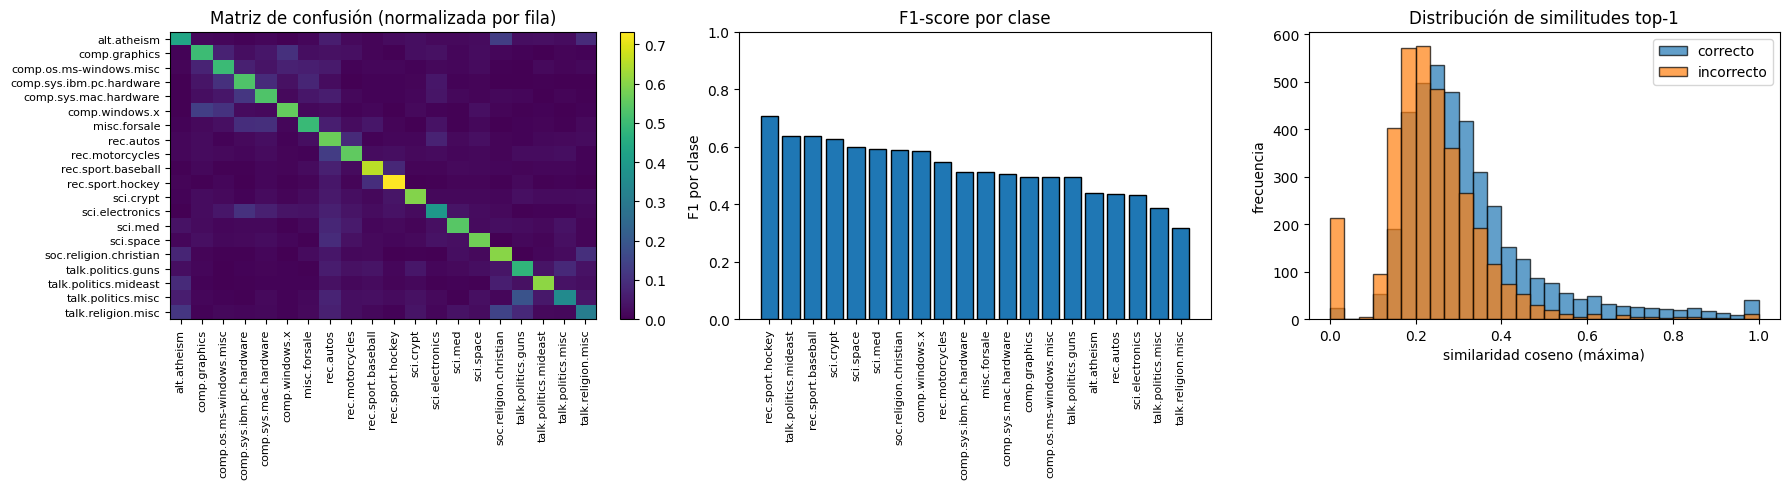

In [29]:
from sklearn.metrics import classification_report

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Matriz de confusión normalizada
df_cm = pd.crosstab(pd.Series(yte, name='true'), pd.Series(y_pred_nn, name='pred'), normalize='index')
im = axes[0].imshow(df_cm.values, aspect='auto', cmap='viridis')
axes[0].set_title("Matriz de confusión (normalizada por fila)")
axes[0].set_xticks(range(len(train.target_names)))
axes[0].set_xticklabels(train.target_names, rotation=90, fontsize=8)
axes[0].set_yticks(range(len(train.target_names)))
axes[0].set_yticklabels(train.target_names, fontsize=8)
fig.colorbar(im, ax=axes[0], fraction=0.046)

# F1 por clase
rep = classification_report(yte, y_pred_nn, target_names=train.target_names, output_dict=True)
df_f1 = pd.DataFrame(rep).T.loc[train.target_names, ["f1-score"]].sort_values("f1-score", ascending=False)
axes[1].bar(df_f1.index, df_f1["f1-score"], edgecolor="black")
axes[1].set_ylabel("F1 por clase")
axes[1].set_xticklabels(df_f1.index, rotation=90, fontsize=8)
axes[1].set_ylim(0,1)
axes[1].set_title("F1-score por clase")

# Distribución de similitudes
Smax = cosine_similarity(Xte, Xtr).max(axis=1)
ok = (y_pred_nn == yte)
axes[2].hist(Smax[ok], bins=30, alpha=0.7, label="correcto", edgecolor="black")
axes[2].hist(Smax[~ok], bins=30, alpha=0.7, label="incorrecto", edgecolor="black")
axes[2].set_xlabel("similaridad coseno (máxima)")
axes[2].set_ylabel("frecuencia")
axes[2].legend()
axes[2].set_title("Distribución de similitudes top-1")

plt.tight_layout()
plt.show()






- El modelo logró una **accuracy de 0.53** y un **f1_macro de 0.53**, lo que indica un desempeño medio, razonable para un enfoque sin entrenamiento ni optimización.  
  En este método, cada documento de test se clasifica según la clase del documento de entrenamiento más similar en el espacio TF-IDF.

- Las clases con mejor rendimiento fueron **rec.sport.hockey (f1 ≈ 0.71)**, **talk.politics.mideast (0.64)** y **rec.sport.baseball (0.64)**.  
  Todas pertenecen a dominios bien delimitados con vocabulario distintivo, lo que facilita la identificación por similitud léxica.

- Los peores resultados se observaron en **talk.religion.misc (f1 ≈ 0.32)** y **talk.politics.misc (0.39)**, categorías más difusas y con lenguaje más general, donde la proximidad de vocabulario entre temas distintos provoca errores frecuentes.

- La **matriz de confusión** muestra diagonales bien definidas en clases técnicas o deportivas y más dispersión en temas de religión y política, evidenciando solapamiento de vocabulario.  
  El **histograma de similitudes** confirma que los aciertos se concentran en valores de coseno más altos, mientras que los errores aparecen cuando la similitud entre el mejor vecino y el documento consultado es baja (<0.3).



# **3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test.
Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.


MultinomialNB

/tmp/ipython-input-1373807787.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_f1_mnb.index, rotation=90, fontsize=8)


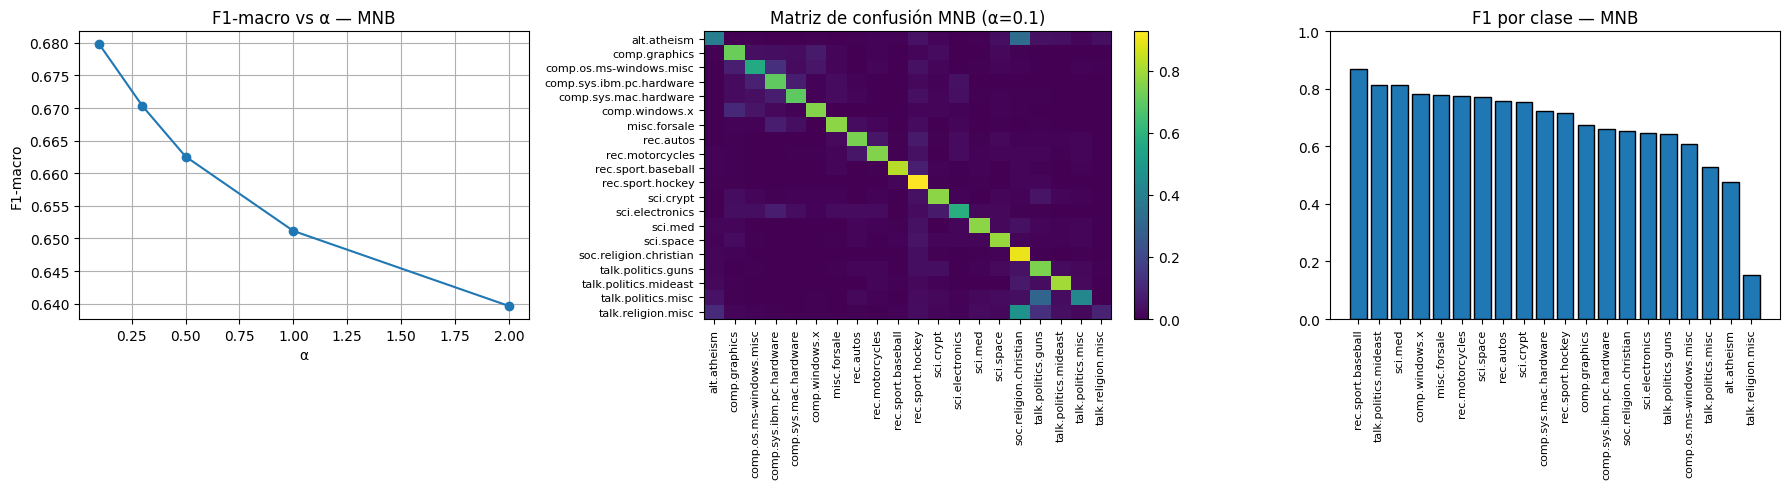

,alpha,f1_macro
0,0.1,0.679764
1,0.3,0.670307
2,0.5,0.662565
3,1.0,0.651157
4,2.0,0.639645


MultinomialNB  α=0.1  accuracy=0.7022  f1_macro=0.6798


In [30]:

try:
    Xtr, Xte
except NameError:
    Xtr, Xte = Xtr_tfidf_tp, Xte_tfidf_tp
ytr, yte = y_train, y_test

alphas = [0.1, 0.3, 0.5, 1.0, 2.0]

mnb_scores = []
for a in alphas:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(Xtr, ytr)
    pred = mnb.predict(Xte)
    mnb_scores.append((a, f1_score(yte, pred, average="macro")))
scores_df = pd.DataFrame(mnb_scores, columns=["alpha", "f1_macro"])
best_alpha_mnb = scores_df.loc[scores_df["f1_macro"].idxmax(), "alpha"]

mnb = MultinomialNB(alpha=best_alpha_mnb)
mnb.fit(Xtr, ytr)
y_pred_mnb = mnb.predict(Xte)

acc_mnb = accuracy_score(yte, y_pred_mnb)
f1_mnb = f1_score(yte, y_pred_mnb, average="macro")
rep_mnb = classification_report(yte, y_pred_mnb, target_names=train.target_names, output_dict=True)

fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].plot(scores_df["alpha"], scores_df["f1_macro"], marker="o")
axes[0].set_title("F1-macro vs α — MNB")
axes[0].set_xlabel("α")
axes[0].set_ylabel("F1-macro")
axes[0].grid(True)

df_cm = pd.crosstab(pd.Series(yte, name='true'), pd.Series(y_pred_mnb, name='pred'), normalize='index')
im = axes[1].imshow(df_cm.values, aspect='auto', cmap='viridis')
axes[1].set_title(f"Matriz de confusión MNB (α={best_alpha_mnb})")
axes[1].set_xticks(range(len(train.target_names)))
axes[1].set_xticklabels(train.target_names, rotation=90, fontsize=8)
axes[1].set_yticks(range(len(train.target_names)))
axes[1].set_yticklabels(train.target_names, fontsize=8)
fig.colorbar(im, ax=axes[1], fraction=0.046)

df_f1_mnb = pd.DataFrame(rep_mnb).T.loc[train.target_names, ["f1-score"]].sort_values("f1-score", ascending=False)
axes[2].bar(df_f1_mnb.index, df_f1_mnb["f1-score"], edgecolor="black")
axes[2].set_title("F1 por clase — MNB")
axes[2].set_ylim(0,1)
axes[2].set_xticklabels(df_f1_mnb.index, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

display(scores_df.sort_values("f1_macro", ascending=False).reset_index(drop=True))
print(f"MultinomialNB  α={best_alpha_mnb}  accuracy={acc_mnb:.4f}  f1_macro={f1_mnb:.4f}")



In [31]:
cm = pd.crosstab(pd.Series(y_test, name="true"), pd.Series(y_pred_mnb, name="pred"), normalize="index")
names = train.target_names
cm.index = cm.columns = names

def top_confusions(cm, k=3):
    rows = []
    for cls in names:
        r = cm.loc[cls].drop(cls).sort_values(ascending=False).head(k)
        for tgt, val in r.items():
            rows.append({"clase_real": cls, "predicha": tgt, "proporcion": float(val)})
    return pd.DataFrame(rows).sort_values(["clase_real","proporcion"], ascending=[True, False])

df_top = top_confusions(cm, k=3)
display(df_top[df_top["clase_real"].str.contains("religion|atheism|christian") | df_top["predicha"].str.contains("politics")].head(20))


,clase_real,predicha,proporcion
0,alt.atheism,soc.religion.christian,0.332288
1,alt.atheism,rec.sport.hockey,0.043887
2,alt.atheism,talk.politics.guns,0.040752
32,rec.sport.hockey,talk.politics.guns,0.012531
33,sci.crypt,talk.politics.guns,0.050505
45,soc.religion.christian,rec.sport.hockey,0.035176
46,soc.religion.christian,alt.atheism,0.017588
47,soc.religion.christian,comp.graphics,0.010050
52,talk.politics.mideast,talk.politics.guns,0.031915
53,talk.politics.mideast,talk.politics.misc,0.023936


- La curva F1-macro vs α muestra **máximo en α=0.1** (~0.68) y caída monótona al aumentar el suavizado.  
- Mejora sustancial frente al modelo anterior (F1-macro ≈0.53 → ≈0.68).  
- Muestra una diagonal fuerte en categorías técnicas, científicas y deportivas, lo que indica buena capacidad de separación en dominios con terminología específica.  
- Las mayores pérdidas se concentran en el bloque **religión ↔ religión** y **política.misc ↔ política.guns**. En religión, *talk.religion.misc* y *alt.atheism* carecen de señal léxica distintiva frente a *soc.religion.christian*.





ComplementNB

/tmp/ipython-input-580056476.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_f1_cnb.index, rotation=90, fontsize=8)


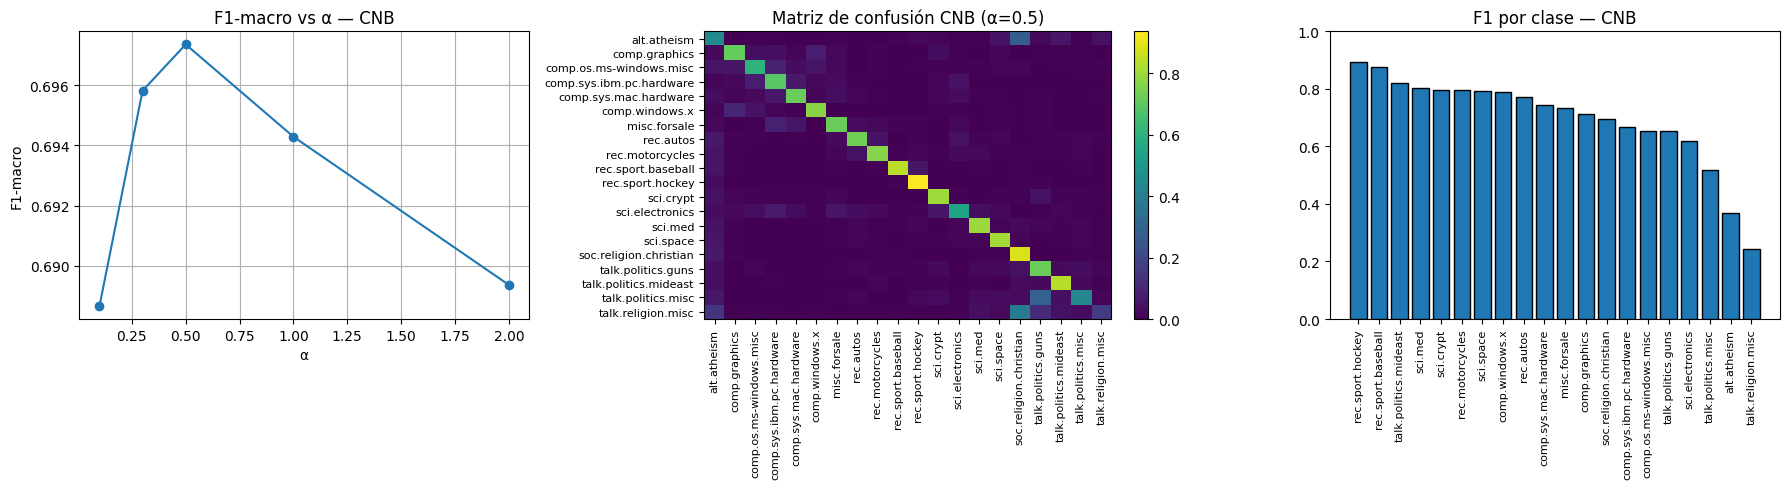

,alpha,f1_macro
0,0.5,0.697363
1,0.3,0.695823
2,1.0,0.694292
3,2.0,0.689360
4,0.1,0.688661


ComplementNB  α=0.5  accuracy=0.7146  f1_macro=0.6974


In [32]:
try:
    alphas
except NameError:
    alphas = [0.1, 0.3, 0.5, 1.0, 2.0]

cnb_scores = []
for a in alphas:
    cnb = ComplementNB(alpha=a)
    cnb.fit(Xtr, ytr)
    pred = cnb.predict(Xte)
    cnb_scores.append((a, f1_score(yte, pred, average="macro")))
scores_cnb = pd.DataFrame(cnb_scores, columns=["alpha", "f1_macro"])
best_alpha_cnb = scores_cnb.loc[scores_cnb["f1_macro"].idxmax(), "alpha"]

cnb = ComplementNB(alpha=best_alpha_cnb)
cnb.fit(Xtr, ytr)
y_pred_cnb = cnb.predict(Xte)

acc_cnb = accuracy_score(yte, y_pred_cnb)
f1_cnb = f1_score(yte, y_pred_cnb, average="macro")
rep_cnb = classification_report(yte, y_pred_cnb, target_names=train.target_names, output_dict=True)

fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].plot(scores_cnb["alpha"], scores_cnb["f1_macro"], marker="o")
axes[0].set_title("F1-macro vs α — CNB")
axes[0].set_xlabel("α")
axes[0].set_ylabel("F1-macro")
axes[0].grid(True)

df_cm = pd.crosstab(pd.Series(yte, name='true'), pd.Series(y_pred_cnb, name='pred'), normalize='index')
im = axes[1].imshow(df_cm.values, aspect='auto', cmap='viridis')
axes[1].set_title(f"Matriz de confusión CNB (α={best_alpha_cnb})")
axes[1].set_xticks(range(len(train.target_names)))
axes[1].set_xticklabels(train.target_names, rotation=90, fontsize=8)
axes[1].set_yticks(range(len(train.target_names)))
axes[1].set_yticklabels(train.target_names, fontsize=8)
fig.colorbar(im, ax=axes[1], fraction=0.046)

df_f1_cnb = pd.DataFrame(rep_cnb).T.loc[train.target_names, ["f1-score"]].sort_values("f1-score", ascending=False)
axes[2].bar(df_f1_cnb.index, df_f1_cnb["f1-score"], edgecolor="black")
axes[2].set_title("F1 por clase — CNB")
axes[2].set_ylim(0,1)
axes[2].set_xticklabels(df_f1_cnb.index, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

display(scores_cnb.sort_values("f1_macro", ascending=False).reset_index(drop=True))
print(f"ComplementNB  α={best_alpha_cnb}  accuracy={acc_cnb:.4f}  f1_macro={f1_cnb:.4f}")



- La curva F1-macro vs α tiene máximo en **α=0.5** (**F1-macro = 0.6974**, **accuracy = 0.7146**). A partir de ahí, valores mayores de α degradan el rendimiento.
- La matriz de confusión mantiene una diagonal nítida en comp.*, sci.* y rec.sport.*, y **reduce parcialmente** las confusiones de religión/política observadas con MNB (aunque **talk.religion.misc** y **alt.atheism** siguen siendo las más débiles).
- El gráfico de F1 por clase confirma mejoras en varias categorías “difusas”, con una distribución más estable que MNB.


- **CNB (α=0.5)** supera a **MNB** en **F1-macro** (≈0.7 vs ≈0.68 ) y también mejora el  **accuracy**, por lo que resulta el **mejor modelo** de los probados.
- Ambos NB mejoran claramente al baseline **1-NN coseno** (F1-macro ≈0.53), evidenciando el beneficio de un clasificador probabilístico con suavizado.
- Persisten errores en el bloque religioso (*talk.religion.misc*, *alt.atheism*) y en algunos cruces políticos, pero **CNB** atenúa mejor el arrastre hacia clases dominantes que **MNB**.




Como punto final se hace un modelo adicional con busqueda de hiperparámetros para intentar mejorar los resultados

,min_df,alpha,f1_macro,accuracy,vocab
4,1,0.30,0.699312,0.716676,101322
5,1,0.35,0.699047,0.716676,101322
7,1,0.45,0.698313,0.716941,101322
6,1,0.40,0.698278,0.716410,101322
3,1,0.25,0.698213,0.715481,101322
8,1,0.50,0.697805,0.716543,101322
31,2,0.65,0.697716,0.714817,39115
30,2,0.60,0.697367,0.714551,39115
28,2,0.50,0.697363,0.714551,39115
25,2,0.35,0.697291,0.714153,39115


/tmp/ipython-input-33618364.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_f1_best.index, rotation=90, fontsize=8)


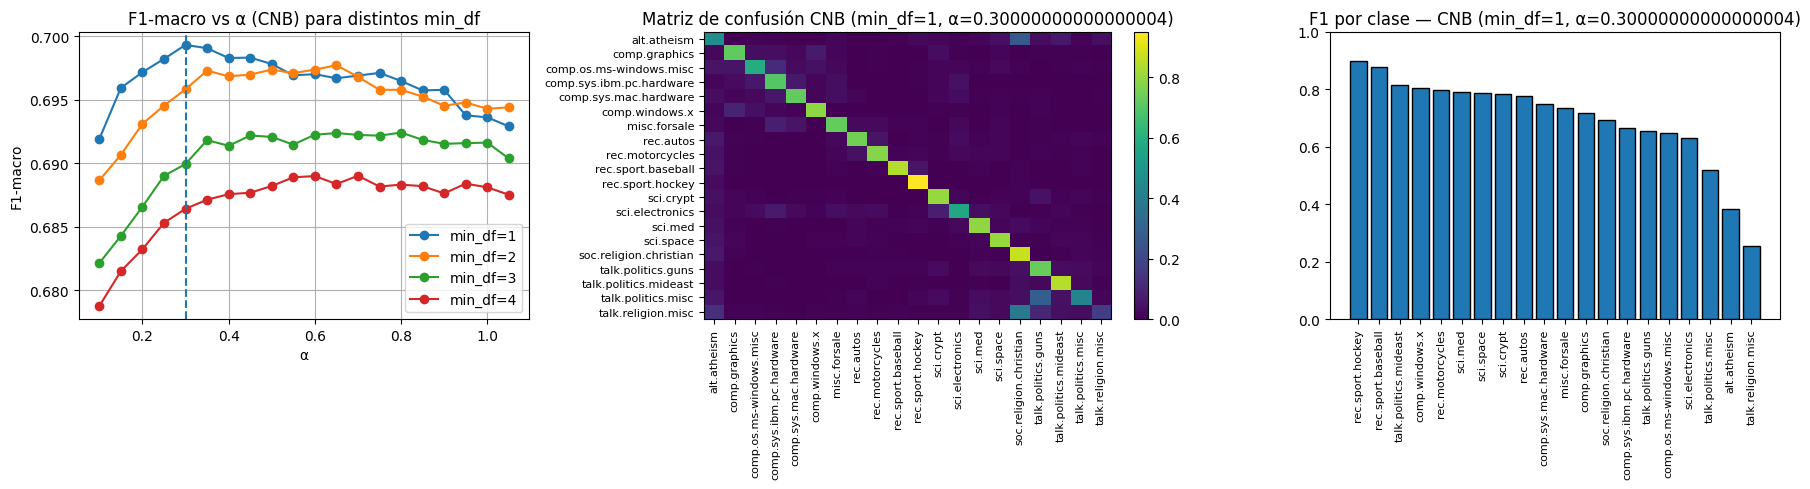

CNB tuned -> min_df=1  alpha=0.30  vocab=101322  accuracy=0.7167  f1_macro=0.6993


In [34]:
min_df_grid = [1,2,3,4]
alpha_grid = np.arange(0.1, 1.1, 0.05)

rows = []
best = {"f1_macro": -1}

for mdf in min_df_grid:
    vec = TfidfVectorizer(stop_words="english", min_df=mdf)
    Xtr_m = vec.fit_transform(X_train)
    Xte_m = vec.transform(X_test)
    for a in alpha_grid:
        cnb = ComplementNB(alpha=a)
        cnb.fit(Xtr_m, y_train)
        pred = cnb.predict(Xte_m)
        f1m = f1_score(y_test, pred, average="macro")
        acc = accuracy_score(y_test, pred)
        rows.append({"min_df": mdf, "alpha": float(a), "f1_macro": f1m, "accuracy": acc, "vocab": len(vec.vocabulary_)})
        if f1m > best["f1_macro"]:
            best = {"min_df": mdf, "alpha": float(a), "f1_macro": f1m, "accuracy": acc, "vec": vec, "pred": pred, "rep": classification_report(y_test, pred, target_names=train.target_names, output_dict=True)}

grid = pd.DataFrame(rows).sort_values(["min_df","alpha"]).reset_index(drop=True)
display(grid.sort_values("f1_macro", ascending=False).head(10))

best_min_df = best["min_df"]
best_alpha = best["alpha"]
best_f1 = best["f1_macro"]
best_acc = best["accuracy"]
y_pred_cnb_tuned = best["pred"]
rep_best = best["rep"]

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for mdf in min_df_grid:
    sub = grid[grid["min_df"]==mdf]
    axes[0].plot(sub["alpha"], sub["f1_macro"], marker="o", label=f"min_df={mdf}")
axes[0].axvline(best_alpha, ls="--")
axes[0].set_title("F1-macro vs α (CNB) para distintos min_df")
axes[0].set_xlabel("α")
axes[0].set_ylabel("F1-macro")
axes[0].legend()
axes[0].grid(True)

df_cm = pd.crosstab(pd.Series(y_test, name='true'), pd.Series(y_pred_cnb_tuned, name='pred'), normalize='index')
im = axes[1].imshow(df_cm.values, aspect='auto', cmap='viridis')
axes[1].set_title(f"Matriz de confusión CNB (min_df={best_min_df}, α={best_alpha})")
axes[1].set_xticks(range(len(train.target_names)))
axes[1].set_xticklabels(train.target_names, rotation=90, fontsize=8)
axes[1].set_yticks(range(len(train.target_names)))
axes[1].set_yticklabels(train.target_names, fontsize=8)
fig.colorbar(im, ax=axes[1], fraction=0.046)

df_f1_best = pd.DataFrame(rep_best).T.loc[train.target_names, ["f1-score"]].sort_values("f1-score", ascending=False)
axes[2].bar(df_f1_best.index, df_f1_best["f1-score"], edgecolor="black")
axes[2].set_title(f"F1 por clase — CNB (min_df={best_min_df}, α={best_alpha})")
axes[2].set_ylim(0,1)
axes[2].set_xticklabels(df_f1_best.index, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

print(f"CNB tuned -> min_df={best_min_df}  alpha={best_alpha:.2f}  vocab={len(best['vec'].vocabulary_)}  accuracy={best_acc:.4f}  f1_macro={best_f1:.4f}")


- Mejor configuración encontrada: **min_df=1, α=0.30**.
- Resultados en test: **F1-macro = 0.6993**, **Accuracy = 0.7167**, **vocab = 101 322**.
- Comparación con el mejor previo (min_df=2, α=0.65):  
  – F1-macro: **0.6993 ↑** vs **0.6974**  
  – Accuracy: **0.7167 ↑** vs **0.7146**  
  – Vocabulario: **101 322 ↑** vs **39 115**  

Bajar `min_df` a 1 aporta términos raros que dan señal útil y sube levemente F1 y accuracy. El costo es un vocabulario mucho más grande (memoria/tiempo) y mayor riesgo de sobreajuste por idiosincrasias.

**Matriz y F1 por clase.** La diagonal se mantiene fuerte en comp.*, sci.* y rec.sport.*. El bloque religioso sigue siendo el más débil, pero con `min_df=1` hay una mejora marginal en algunas subclases; el arrastre hacia clases dominantes persiste, aunque algo atenuado frente a configuraciones más agresivas de `min_df`.

dado que las mejroas son muy pequeñas, se prioriza eficiencia y estabilidad, la alternativa **min_df=2, α=0.65** queda muy cerca en F1 con 2.6× menos vocabulario.




### Comparativa de modelos

| Modelo                              | Vectorización                | α      | min_df | Accuracy | F1-macro | Observaciones principales |
|------------------------------------|------------------------------|--------|--------|-----------|-----------|----------------------------|
| **1-NN (Zero-Shot por coseno)**    | TF-IDF (stop_words=english, min_df=2) | –      | 2      | 0.5325    | 0.5268    | Método basado en similitud coseno. Sin entrenamiento. Buenas separaciones en temas técnicos, pero pobre generalización. |
| **MultinomialNB (MNB)**            | TF-IDF (stop_words=english, min_df=2) | 0.10   | 2      | 0.7074    | 0.6800    | Buen equilibrio global. Mayor dispersión en clases religiosas/políticas. |
| **ComplementNB (CNB base)**        | TF-IDF (stop_words=english, min_df=2) | 0.50   | 2      | 0.7146    | 0.6974    | Mejora sobre MNB en clases desbalanceadas. Estabilidad por clase . |
| **ComplementNB (CNB afinado)**     | TF-IDF (stop_words=english, min_df=1) | 0.30   | 1      | **0.7167**| **0.6993**| Mejor desempeño global. Incrementa vocabulario (101k términos). Ligeramente superior en F1 y accuracy. |

---

### Síntesis
- Los modelos **Naïve Bayes** superan ampliamente al enfoque **1-NN** en todas las métricas.  
- **ComplementNB** mantiene la mejor relación entre rendimiento y robustez.  
- El ajuste fino con `min_df=1, α=0.30` logra el **mayor F1-macro (0.6993)** y **accuracy (0.7167)**, aunque con un vocabulario más grande.  



# **4**. Transponer la matriz documento-término.
De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np, pandas as pd

min_df_words = 2
vec_words = TfidfVectorizer(stop_words="english", min_df=min_df_words)
Xw = vec_words.fit_transform(X_train)
XwT = Xw.T.tocsc()

vocab = np.array(vec_words.get_feature_names_out())
idx = {t:i for i,t in enumerate(vocab)}
row_norms = np.sqrt(XwT.power(2).sum(axis=1)).A1 + 1e-12

def top_similar_words(words, k=5):
    out = []
    for w in words:
        if w not in idx:
            out.append({"palabra": w, "similar": None, "similitud": None})
            continue
        i = idx[w]
        vi = XwT.getrow(i).T
        sims_num = (XwT @ vi).toarray().ravel()
        sims = sims_num / (row_norms * row_norms[i])
        sims[i] = 0.0
        top = np.argpartition(sims, -k)[-k:]
        top = top[np.argsort(sims[top])[::-1]]
        for j in top:
            out.append({"palabra": w, "similar": vocab[j], "similitud": float(sims[j])})
    return pd.DataFrame(out)

selected_words = ["windows", "mac", "god", "space", "graphics"]
df_sim_words = top_similar_words(selected_words, k=5)
display(df_sim_words)
print(f"vocabulario={len(vocab)}  min_df={min_df_words}")




,palabra,similar,similitud
0,windows,dos,0.301480
1,windows,ms,0.232601
2,windows,microsoft,0.217860
3,windows,nt,0.206052
4,windows,file,0.192933
5,mac,se,0.206429
6,mac,tte,0.168859
7,mac,deluxe,0.166039
8,mac,kth,0.154241
9,mac,nada,0.151224


vocabulario=39115  min_df=2


**Metodología.** Usé TF-IDF unigrama con `stop_words="english"` y `min_df=2`, transpuesta a matriz término-documento. Para cada palabra, calculé coseno vs. todas las demás con producto disperso (sin armar la matriz completa por tamaño de la misma).


La similaridad entre palabras obtenida a partir de la matriz término–documento
no representa "sinonimia", sino coincidencia de contexto en los documentos.
TF-IDF penaliza términos muy frecuentes y destaca vocabulario informativo,
permitiendo que aparezcan agrupaciones temáticamente coherentes (e.g. god ↔ jesus,
windows ↔ microsoft, space ↔ nasa). Sin embargo, persiste ruido por nombres propios,
acrónimos y tokens específicos del dominio, lo cual es característico del corpus
20 Newsgroups.

